In [ ]:
# Install the necessary dependencies

import os
import sys
!{sys.executable} -m pip install --quiet pandas scikit-learn numpy matplotlib jupyterlab_myst ipython

---
license:
    code: MIT
    content: CC-BY-4.0
github: https://github.com/ocademy-ai/machine-learning
venue: By Ocademy
open_access: true
bibliography:
  - https://raw.githubusercontent.com/ocademy-ai/machine-learning/main/open-machine-learning-jupyter-book/references.bib
---

# Generative Adversarial Networks 

The original purpose of Generative adversarial networks(GAN) is to generate new data. It classically generates new images, but is applicable to wide range of domains. It learns the training set distribution and can generate new images that have never been seen before. In contrast to e.g., autoregressive models or RNNs (generating one word at a time), GANs generate the whole output all at once.

GAN stands for Generative Adversarial Network, a type of artificial intelligence framework introduced by Ian Goodfellow and his colleagues in 2014. GANs are a class of machine learning systems designed to generate new data instances that resemble a given dataset. The core idea behind GANs is to pit two neural networks against each other: a generator and a discriminator.

The training process of GANs involves a competitive game between the generator and the discriminator:

`Generator Training`: The generator tries to produce data samples that are indistinguishable from real data, aiming to fool the discriminator.

`Discriminator Training`: The discriminator is trained to become better at distinguishing real data from fake data generated by the generator.

The training process continues iteratively, with both networks improving over time. Ideally, this adversarial training results in the generator producing high-quality synthetic data that is difficult for the discriminator to differentiate from real data.

GANs have gained significant attention and popularity due to their ability to generate realistic images, music, text, and more. They have numerous applications, including image synthesis, style transfer, data augmentation, and even generating synthetic data for training machine learning models when real data is limited or expensive to obtain. However, training GANs can be challenging and often requires careful tuning of hyperparameters and architectures to achieve desirable results.

## Code

### Import Necessary Packages
First set up the necessary tools and environment for working with GANs using TensorFlow. It provides utility functions for data handling and visualization, as well as preprocessed data for experimentation. 

In [1]:
import tensorflow as tf
import requests
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.shape) for p in model.weights])
    return param_count
url = 'https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/Gan/gan-checks-tf.npz'
response = requests.get(url)
with open('gan-checks-tf.npz', 'wb') as f:
    f.write(response.content)

# Now you can use np.load on the downloaded file
answers = np.load('gan-checks-tf.npz')

NOISE_DIM = 96

### MNIST Dataset
Set up a convenient way to iterate over minibatches of the MNIST dataset for training or evaluation purposes. It also provides a method to visualize a subset of the dataset.

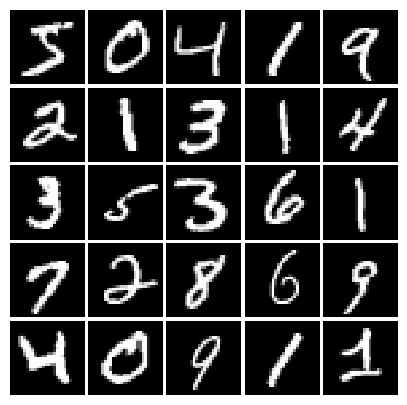

In [3]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the MNIST data
        
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, _ = tf.keras.datasets.mnist.load_data()
        X, y = train
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 
mnist = MNIST(batch_size=25) 
show_images(mnist.X[:25])

### Leaky_relu Function
The leaky_relu function computes the leaky rectified linear unit (ReLU) activation function, which is a variant of the standard ReLU function. This function is commonly used in neural network architectures, especially when dealing with vanishing gradient issues associated with traditional ReLU activations.

In [4]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    x = tf.nn.leaky_relu(x,alpha)
    return x
    pass

### Sample_noise Function
This function is useful for generating random noise vectors that can be used as input to a generative model, such as a GAN (Generative Adversarial Network), to produce synthetic data.

In [5]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    noise = tf.random.uniform([batch_size,dim],minval = -1,maxval = 1)
    return noise
    pass

### Discriminator Function
These functions are essential for defining and testing the discriminator and generator models in a GAN architecture. They ensure that the models have the correct architecture and number of parameters before training.

In [6]:
def discriminator():
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    model = tf.keras.models.Sequential([
        # TODO: implement architecture
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        tf.keras.layers.InputLayer(784),
        tf.keras.layers.Dense(256),
        tf.keras.layers.LeakyReLU(0.01),
        tf.keras.layers.Dense(256),
        tf.keras.layers.LeakyReLU(0.01),
        tf.keras.layers.Dense(1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ])
    return model
def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in discriminator.')
        
test_discriminator()

def generator(noise_dim=NOISE_DIM):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    model = tf.keras.models.Sequential([
        # TODO: implement architecture
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        tf.keras.layers.InputLayer(noise_dim),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(784,activation = tf.nn.tanh)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ])
    return model
def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in generator.')
        
test_generator()



Correct number of parameters in discriminator.
Correct number of parameters in generator.


### Discriminator_loss Funtion
Overall, these functions are used to compute and test the discriminator and generator losses in a Generative Adversarial Network (GAN) framework. The discriminator loss aims to differentiate between real and fake data, while the generator loss aims to fool the discriminator by generating realistic fake data.

In [7]:
def discriminator_loss(logits_real, logits_fake):

    loss = None
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    real_loss = cross_entropy(tf.ones_like(logits_real), logits_real)
    fake_loss = cross_entropy(tf.zeros_like(logits_fake), logits_fake)
    loss = real_loss + fake_loss
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    loss = None
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    loss = cross_entropy(tf.ones_like(logits_fake), logits_fake)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(tf.constant(logits_real),
                                tf.constant(logits_fake))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 0


### Test_generator_loss Function
This function is useful for testing the correctness of the implementation of the generator loss function. It ensures that the computed loss matches the expected loss within an acceptable error threshold.

In [8]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(tf.constant(logits_fake))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Maximum error in g_loss: 7.19722e-17


### Get_solvers Function
This function is essential for setting up the optimizers used during the training of the discriminator and generator in a GAN framework. It ensures consistent learning rates and beta1 parameters for both components during training.

In [9]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.optimizers.Adam with correct learning_rate and beta1
    - G_solver: instance of tf.optimizers.Adam with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    D_solver = tf.optimizers.Adam(learning_rate,beta1)
    G_solver = tf.optimizers.Adam(learning_rate,beta1)
    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return D_solver, G_solver
# a giant helper function
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss,\
              show_every=20, print_every=20, batch_size=128, num_epochs=10, noise_size=96):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - D: Discriminator model
    - G: Generator model
    - D_solver: an Optimizer for Discriminator
    - G_solver: an Optimizer for Generator
    - generator_loss: Generator loss
    - discriminator_loss: Discriminator loss
    Returns:
        Nothing
    """
    mnist = MNIST(batch_size=batch_size, shuffle=True)
    
    iter_count = 0
    for epoch in range(num_epochs):
        for (x, _) in mnist:
            with tf.GradientTape() as tape:
                real_data = x
                logits_real = D(preprocess_img(real_data))

                g_fake_seed = sample_noise(batch_size, noise_size)
                fake_images = G(g_fake_seed)
                logits_fake = D(tf.reshape(fake_images, [batch_size, 784]))
                d_total_error = discriminator_loss(logits_real, logits_fake)
                d_gradients = tape.gradient(d_total_error, D.trainable_variables)      
                D_solver.apply_gradients(zip(d_gradients, D.trainable_variables))
            
            with tf.GradientTape() as tape:
                g_fake_seed = sample_noise(batch_size, noise_size)
                fake_images = G(g_fake_seed)

                gen_logits_fake = D(tf.reshape(fake_images, [batch_size, 784]))
                g_error = generator_loss(gen_logits_fake)
                g_gradients = tape.gradient(g_error, G.trainable_variables)      
                G_solver.apply_gradients(zip(g_gradients, G.trainable_variables))

            if (iter_count % show_every == 0):
                print('Epoch: {}, Iter: {}, D: {:.4}, G:{:.4}'.format(epoch, iter_count,d_total_error,g_error))
                imgs_numpy = fake_images.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
            iter_count += 1
    
    # random noise fed into our generator
    z = sample_noise(batch_size, noise_size)
    # generated images
    G_sample = G(z)
    print('Final images')
    show_images(G_sample[:16])
    plt.show()

Epoch: 0, Iter: 0, D: 1.282, G:0.7291


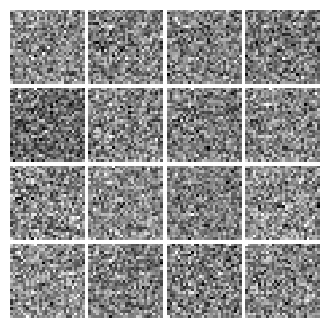

Epoch: 0, Iter: 20, D: 0.5961, G:0.939


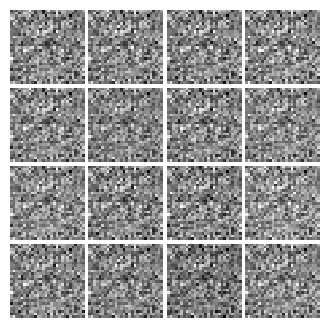

Epoch: 0, Iter: 40, D: 0.4743, G:1.119


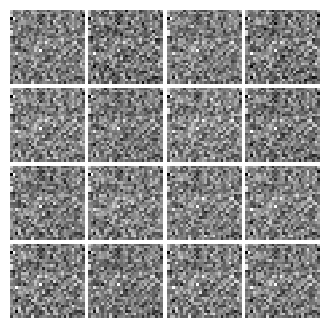

Epoch: 0, Iter: 60, D: 0.9576, G:2.328


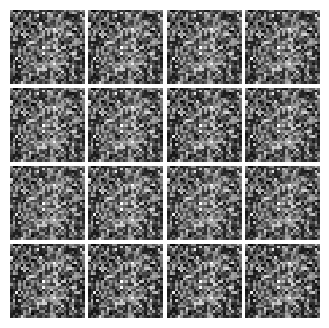

Epoch: 0, Iter: 80, D: 1.114, G:1.435


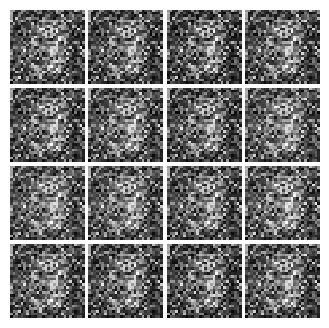

Epoch: 0, Iter: 100, D: 1.359, G:0.6084


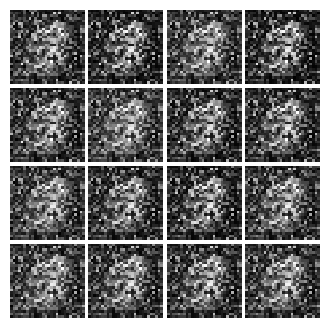

Epoch: 0, Iter: 120, D: 1.235, G:2.109


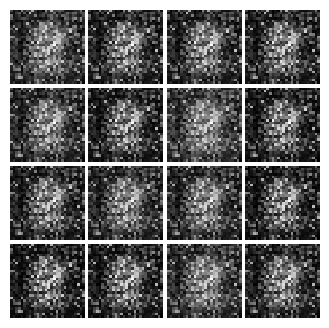

Epoch: 0, Iter: 140, D: 1.177, G:0.4641


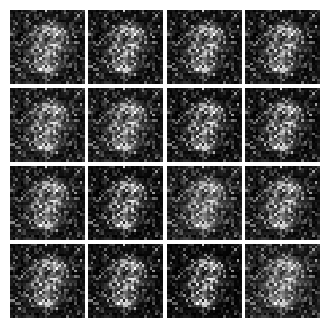

Epoch: 0, Iter: 160, D: 1.395, G:0.916


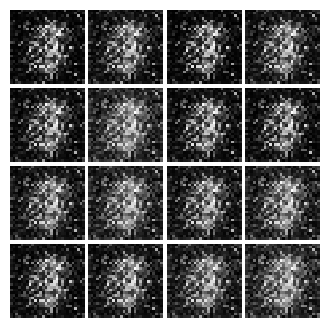

Epoch: 0, Iter: 180, D: 1.141, G:1.163


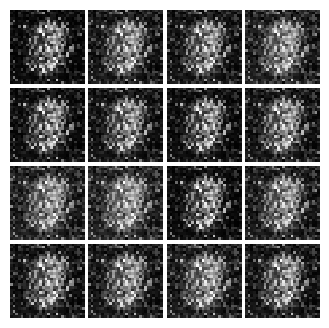

Epoch: 0, Iter: 200, D: 0.8032, G:1.741


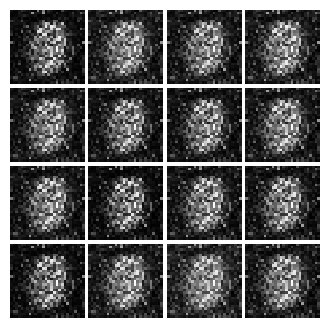

Epoch: 0, Iter: 220, D: 1.62, G:1.159


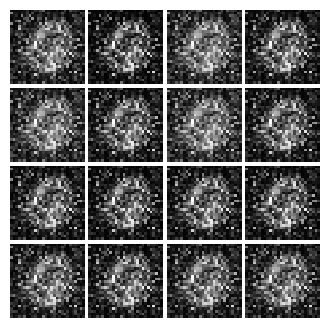

Epoch: 0, Iter: 240, D: 1.724, G:1.174


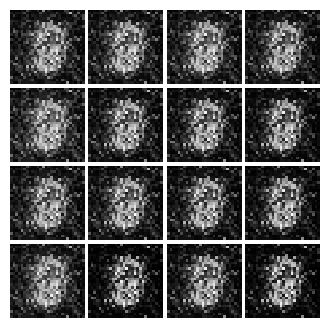

Epoch: 0, Iter: 260, D: 1.691, G:0.8409


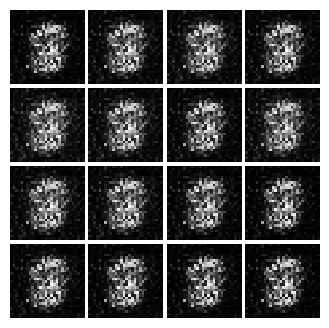

Epoch: 0, Iter: 280, D: 1.259, G:1.286


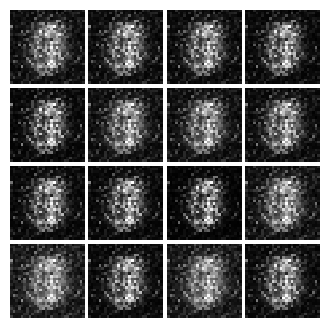

Epoch: 0, Iter: 300, D: 1.109, G:1.362


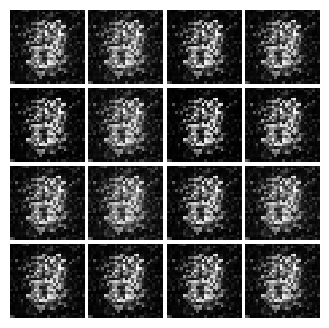

Epoch: 0, Iter: 320, D: 0.8914, G:2.036


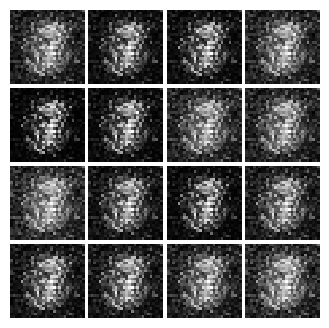

Epoch: 0, Iter: 340, D: 0.9051, G:1.52


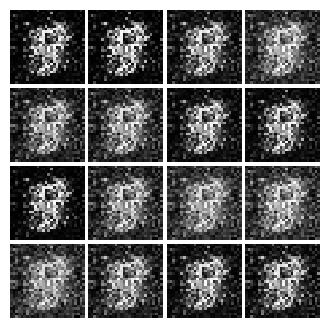

Epoch: 0, Iter: 360, D: 1.123, G:0.9118


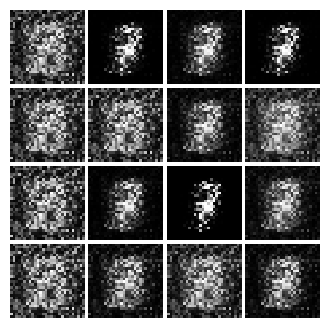

Epoch: 0, Iter: 380, D: 1.122, G:1.173


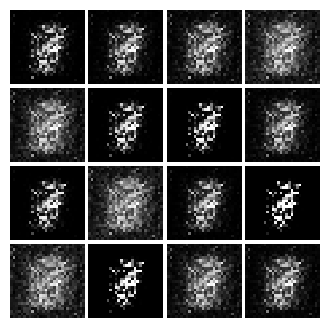

Epoch: 0, Iter: 400, D: 1.519, G:1.217


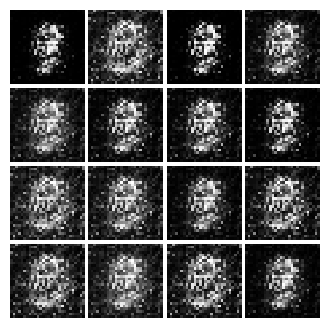

Epoch: 0, Iter: 420, D: 1.587, G:0.8321


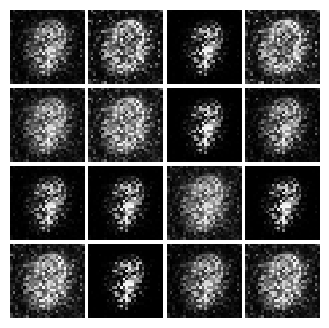

Epoch: 0, Iter: 440, D: 1.332, G:0.9728


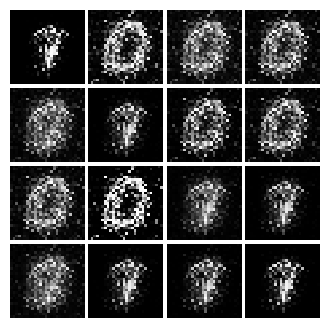

Epoch: 0, Iter: 460, D: 1.056, G:0.8474


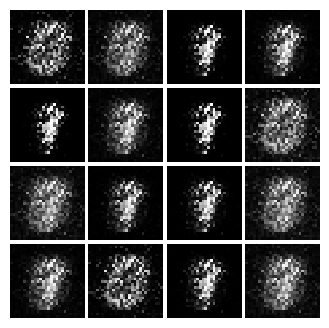

Epoch: 1, Iter: 480, D: 1.191, G:1.047


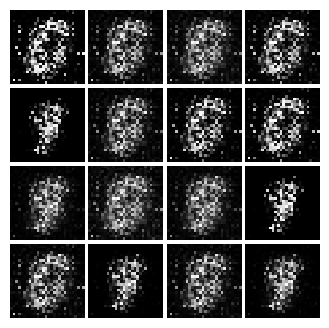

Epoch: 1, Iter: 500, D: 1.111, G:1.135


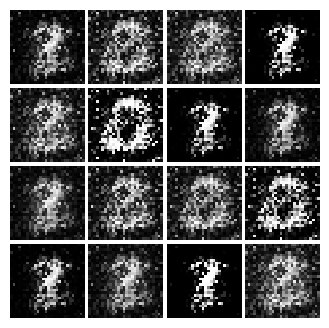

Epoch: 1, Iter: 520, D: 1.527, G:0.3413


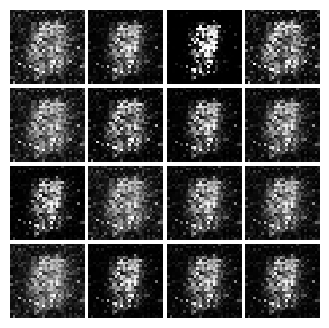

Epoch: 1, Iter: 540, D: 1.148, G:1.036


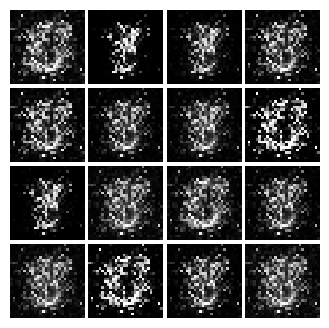

Epoch: 1, Iter: 560, D: 1.07, G:0.738


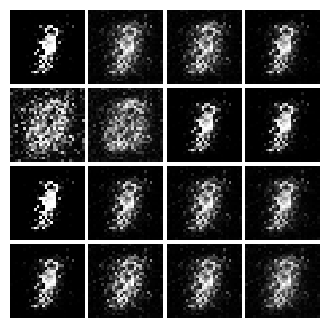

Epoch: 1, Iter: 580, D: 1.013, G:2.329


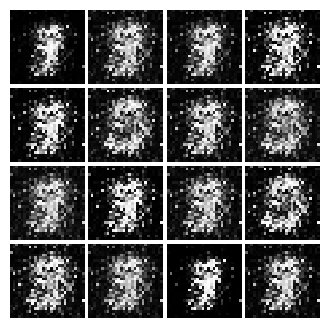

Epoch: 1, Iter: 600, D: 1.137, G:1.13


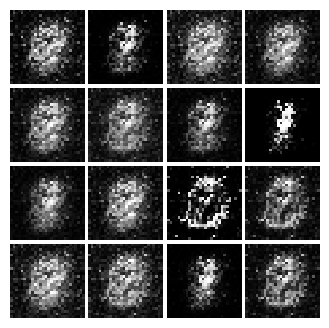

Epoch: 1, Iter: 620, D: 1.284, G:1.294


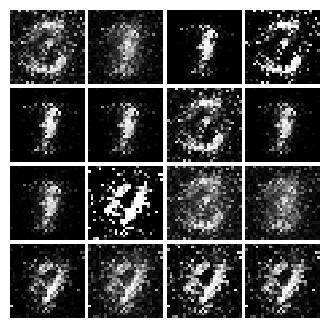

Epoch: 1, Iter: 640, D: 0.9187, G:0.6909


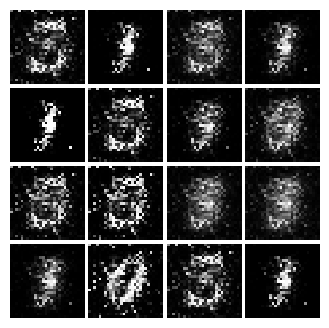

Epoch: 1, Iter: 660, D: 1.143, G:1.639


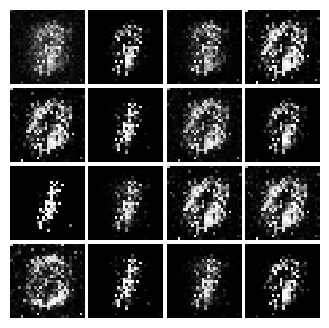

Epoch: 1, Iter: 680, D: 1.006, G:1.272


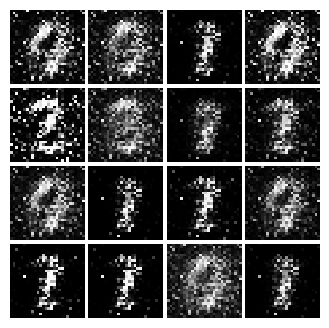

Epoch: 1, Iter: 700, D: 0.9839, G:1.781


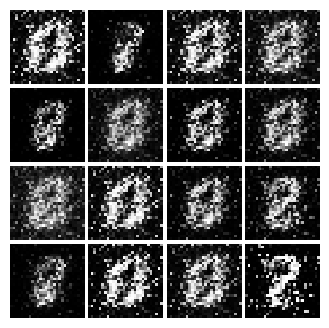

Epoch: 1, Iter: 720, D: 1.399, G:2.699


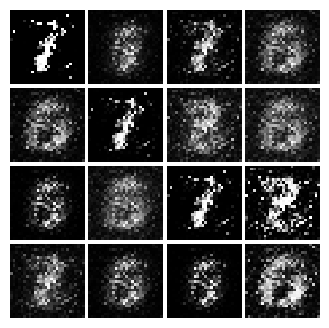

Epoch: 1, Iter: 740, D: 1.193, G:1.47


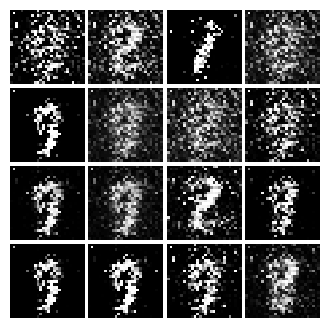

Epoch: 1, Iter: 760, D: 0.9832, G:1.137


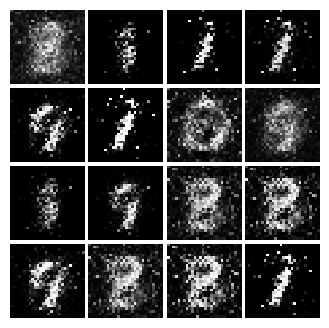

Epoch: 1, Iter: 780, D: 1.109, G:1.772


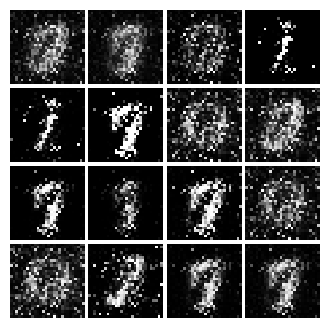

Epoch: 1, Iter: 800, D: 1.169, G:1.342


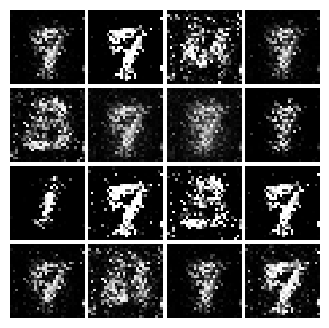

Epoch: 1, Iter: 820, D: 1.057, G:1.127


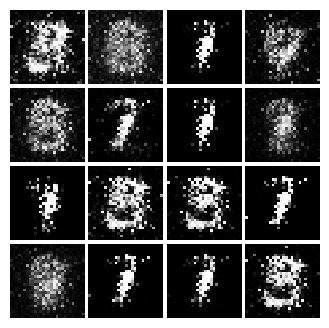

Epoch: 1, Iter: 840, D: 1.171, G:3.187


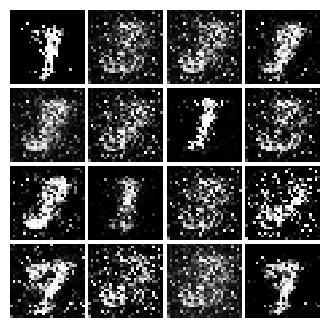

Epoch: 1, Iter: 860, D: 1.12, G:1.073


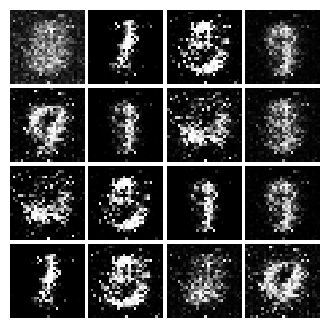

Epoch: 1, Iter: 880, D: 1.336, G:1.015


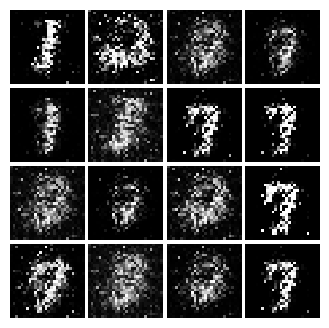

Epoch: 1, Iter: 900, D: 1.17, G:1.144


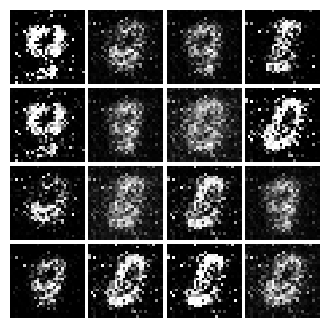

Epoch: 1, Iter: 920, D: 1.381, G:1.695


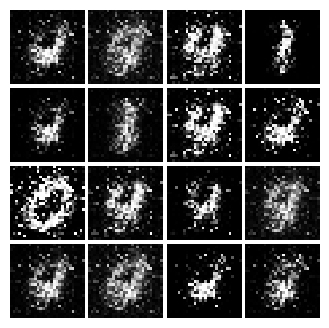

Epoch: 2, Iter: 940, D: 1.134, G:1.427


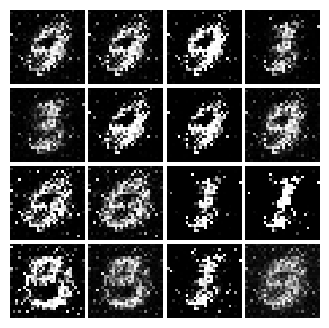

Epoch: 2, Iter: 960, D: 1.202, G:5.209


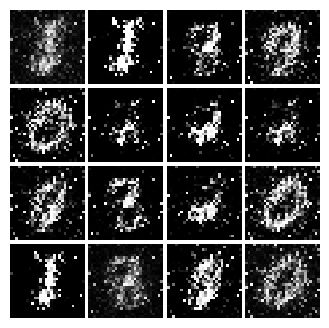

Epoch: 2, Iter: 980, D: 2.34, G:0.1736


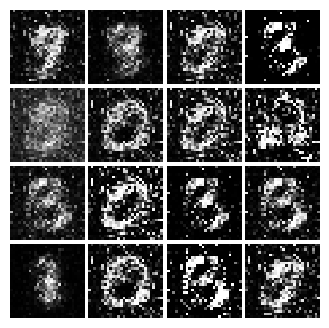

Epoch: 2, Iter: 1000, D: 1.087, G:1.454


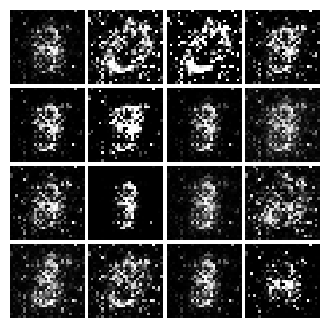

Epoch: 2, Iter: 1020, D: 1.043, G:1.649


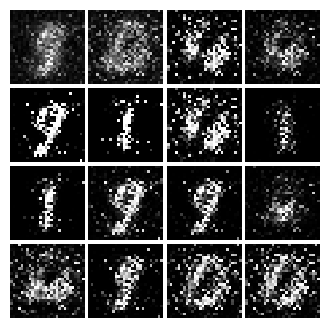

Epoch: 2, Iter: 1040, D: 1.081, G:1.226


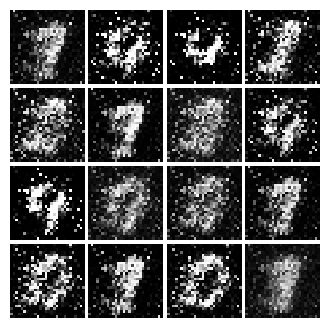

Epoch: 2, Iter: 1060, D: 1.148, G:1.164


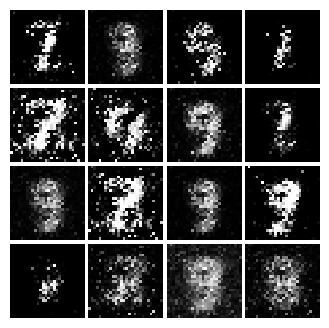

Epoch: 2, Iter: 1080, D: 1.009, G:0.9417


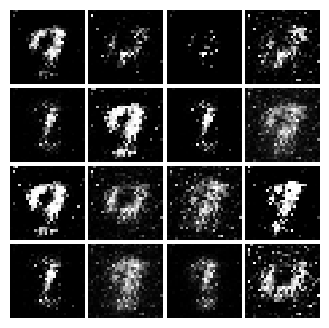

Epoch: 2, Iter: 1100, D: 1.105, G:1.153


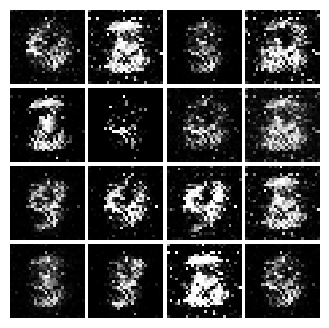

Epoch: 2, Iter: 1120, D: 0.9006, G:1.813


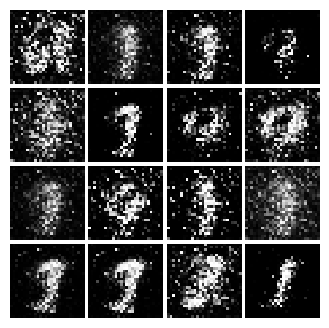

Epoch: 2, Iter: 1140, D: 1.15, G:1.318


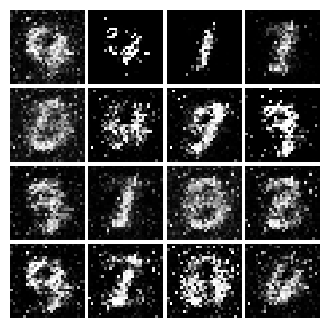

Epoch: 2, Iter: 1160, D: 1.155, G:0.9754


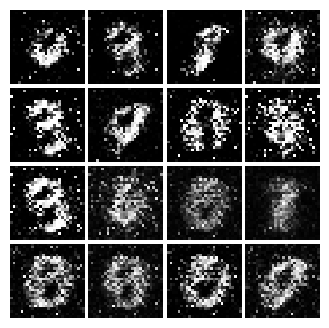

Epoch: 2, Iter: 1180, D: 1.596, G:0.7352


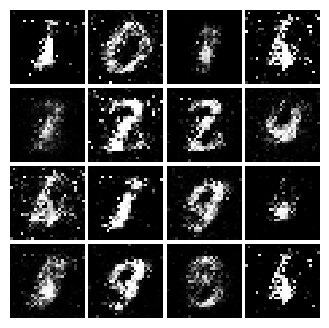

Epoch: 2, Iter: 1200, D: 1.411, G:0.986


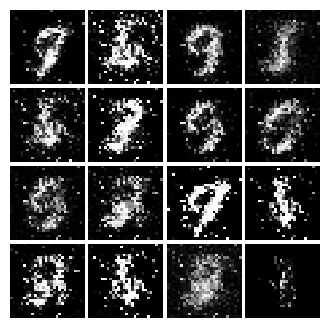

Epoch: 2, Iter: 1220, D: 1.138, G:1.198


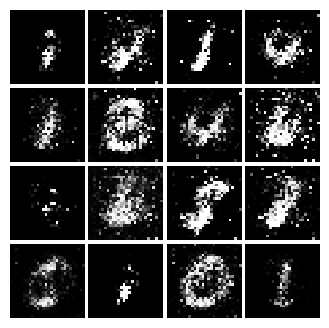

Epoch: 2, Iter: 1240, D: 1.222, G:0.9413


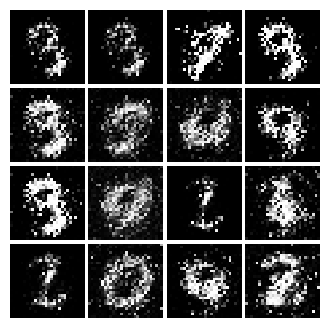

Epoch: 2, Iter: 1260, D: 1.366, G:0.786


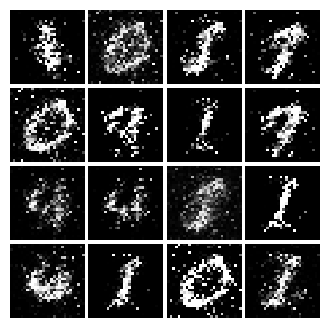

Epoch: 2, Iter: 1280, D: 1.189, G:0.9543


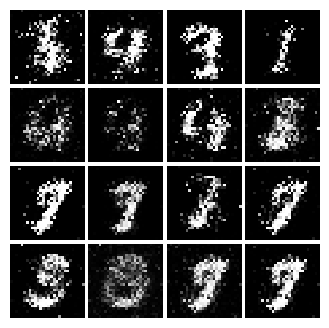

Epoch: 2, Iter: 1300, D: 1.241, G:1.199


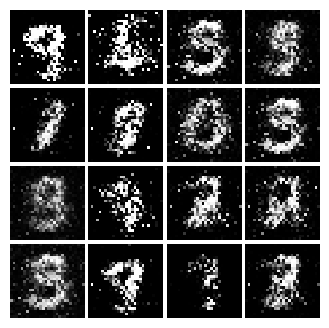

Epoch: 2, Iter: 1320, D: 1.238, G:1.244


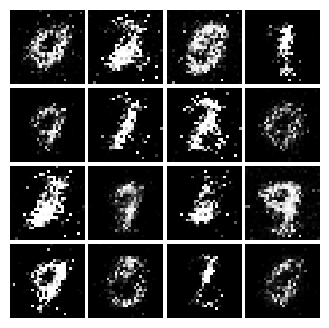

Epoch: 2, Iter: 1340, D: 1.299, G:0.7954


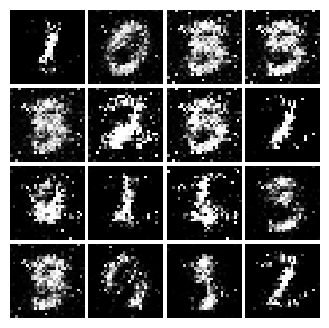

Epoch: 2, Iter: 1360, D: 1.307, G:1.064


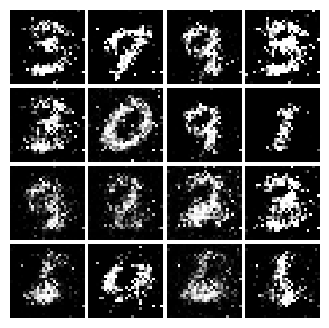

Epoch: 2, Iter: 1380, D: 1.141, G:1.252


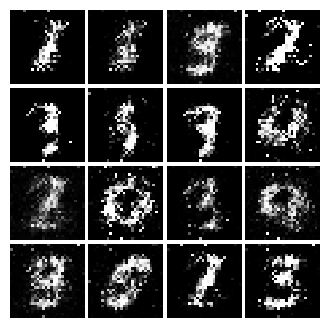

Epoch: 2, Iter: 1400, D: 1.507, G:1.846


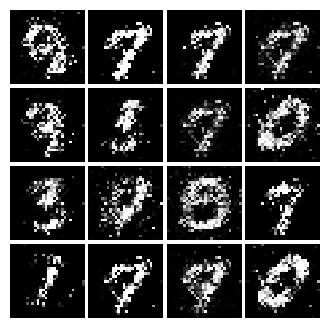

Epoch: 3, Iter: 1420, D: 1.823, G:1.181


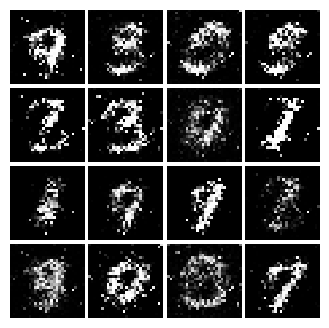

Epoch: 3, Iter: 1440, D: 1.233, G:2.1


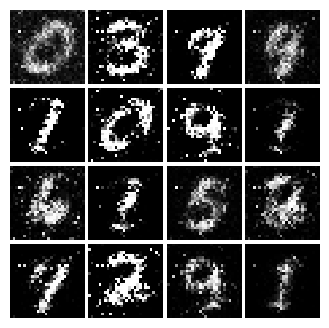

Epoch: 3, Iter: 1460, D: 1.347, G:1.221


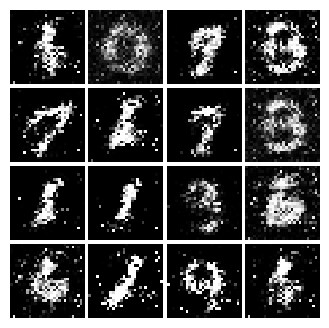

Epoch: 3, Iter: 1480, D: 1.322, G:0.8337


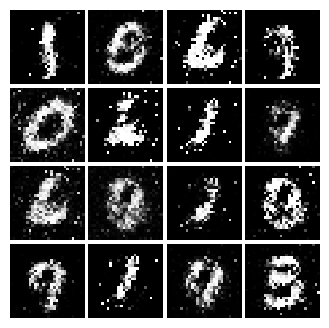

Epoch: 3, Iter: 1500, D: 1.285, G:0.7784


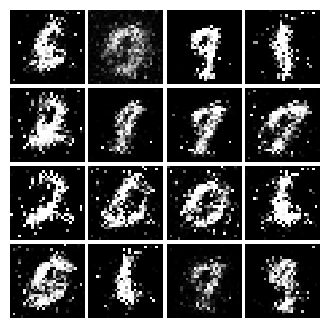

Epoch: 3, Iter: 1520, D: 1.196, G:0.8878


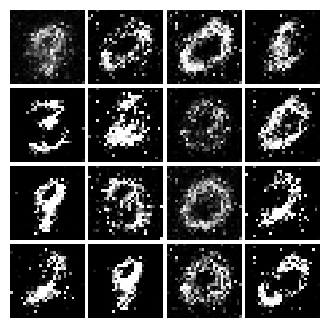

Epoch: 3, Iter: 1540, D: 1.352, G:0.8392


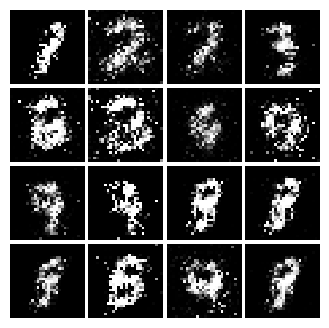

Epoch: 3, Iter: 1560, D: 1.309, G:0.8798


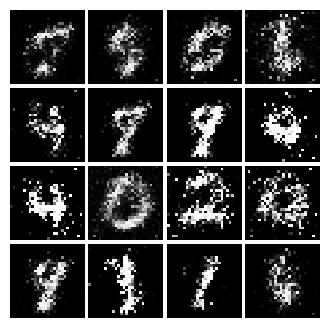

Epoch: 3, Iter: 1580, D: 1.337, G:1.744


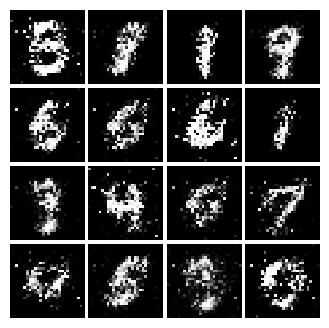

Epoch: 3, Iter: 1600, D: 1.282, G:0.9145


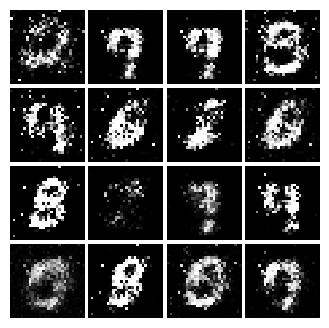

Epoch: 3, Iter: 1620, D: 1.188, G:0.8636


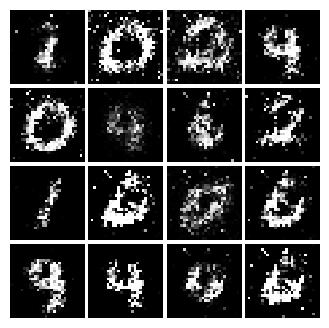

Epoch: 3, Iter: 1640, D: 1.218, G:1.075


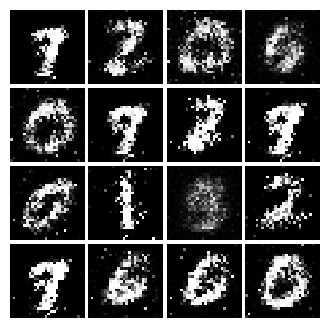

Epoch: 3, Iter: 1660, D: 1.237, G:1.639


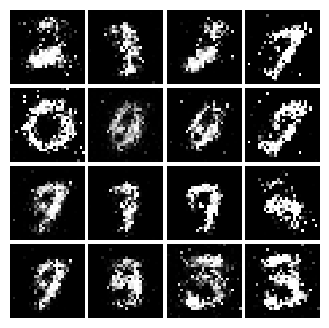

Epoch: 3, Iter: 1680, D: 1.23, G:0.8684


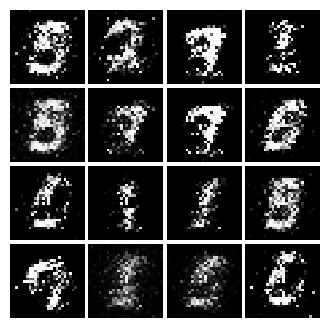

Epoch: 3, Iter: 1700, D: 1.252, G:0.8889


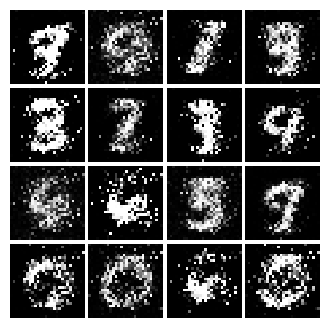

Epoch: 3, Iter: 1720, D: 1.207, G:0.9694


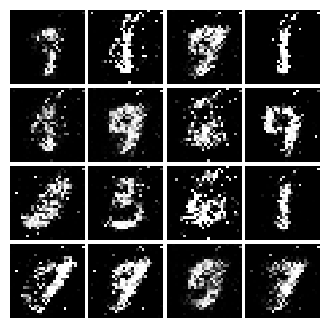

Epoch: 3, Iter: 1740, D: 1.239, G:1.15


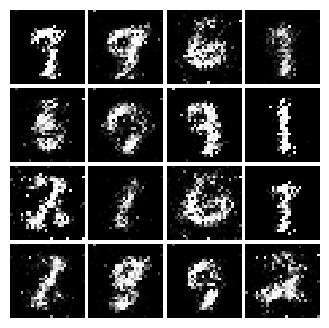

Epoch: 3, Iter: 1760, D: 1.247, G:1.015


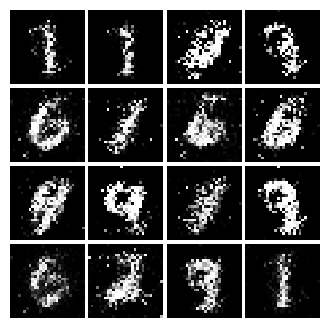

Epoch: 3, Iter: 1780, D: 1.047, G:1.203


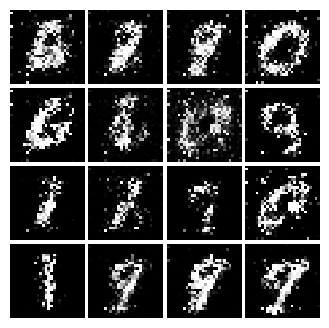

Epoch: 3, Iter: 1800, D: 1.22, G:1.06


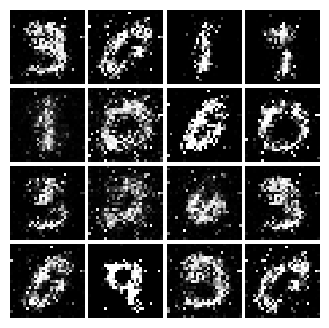

Epoch: 3, Iter: 1820, D: 1.209, G:0.996


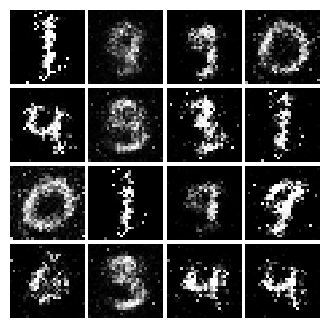

Epoch: 3, Iter: 1840, D: 1.251, G:0.952


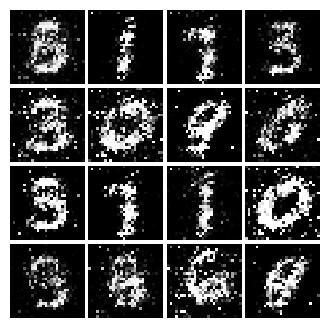

Epoch: 3, Iter: 1860, D: 1.227, G:1.546


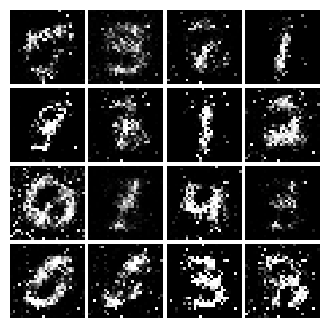

Epoch: 4, Iter: 1880, D: 1.325, G:0.9404


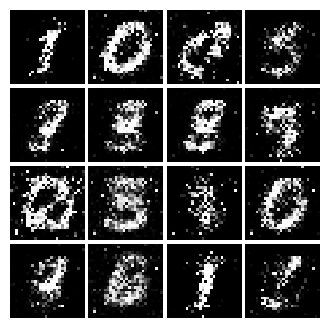

Epoch: 4, Iter: 1900, D: 1.239, G:1.051


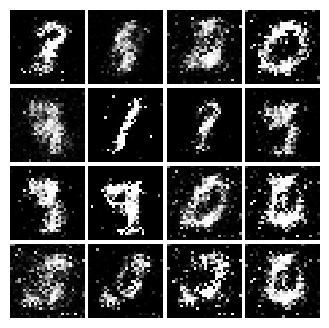

Epoch: 4, Iter: 1920, D: 1.175, G:0.9562


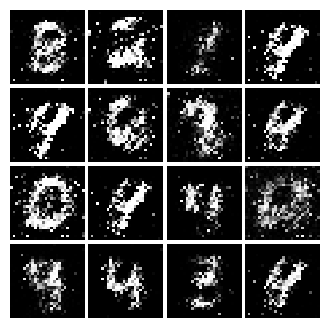

Epoch: 4, Iter: 1940, D: 1.267, G:0.8827


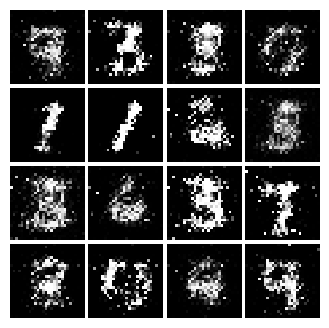

Epoch: 4, Iter: 1960, D: 1.358, G:0.8997


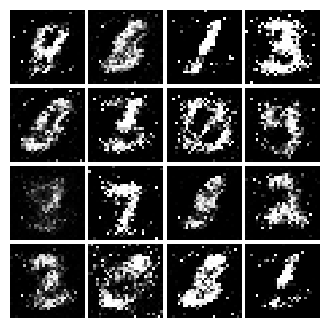

Epoch: 4, Iter: 1980, D: 1.198, G:0.8215


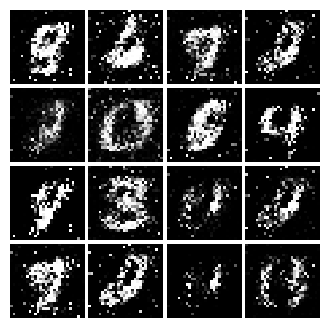

Epoch: 4, Iter: 2000, D: 1.33, G:0.7475


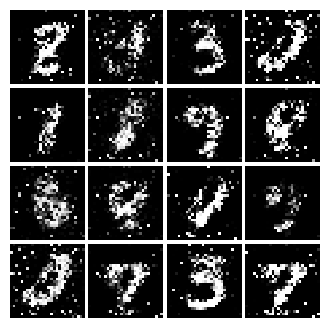

Epoch: 4, Iter: 2020, D: 1.311, G:0.9989


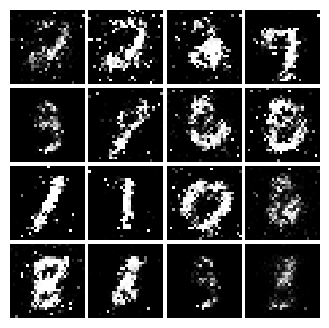

Epoch: 4, Iter: 2040, D: 1.208, G:1.183


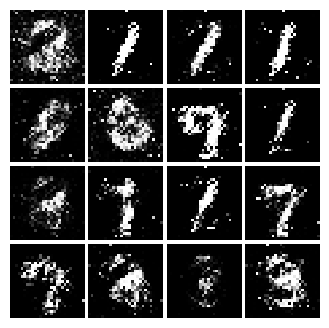

Epoch: 4, Iter: 2060, D: 1.297, G:0.8808


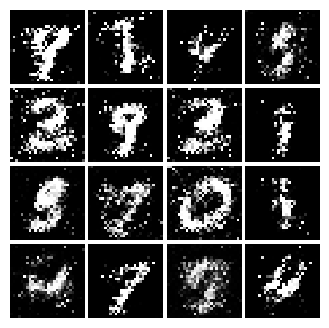

Epoch: 4, Iter: 2080, D: 1.231, G:0.8134


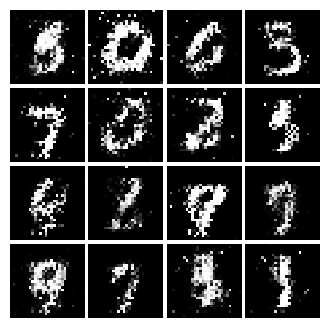

Epoch: 4, Iter: 2100, D: 1.403, G:0.8431


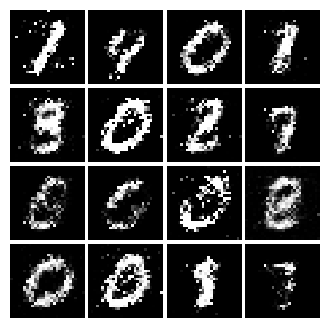

Epoch: 4, Iter: 2120, D: 1.271, G:0.8456


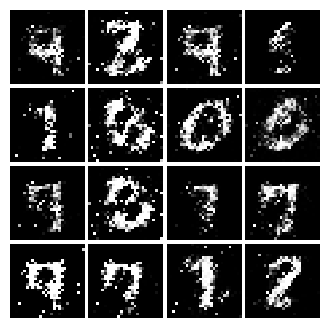

Epoch: 4, Iter: 2140, D: 1.18, G:0.9747


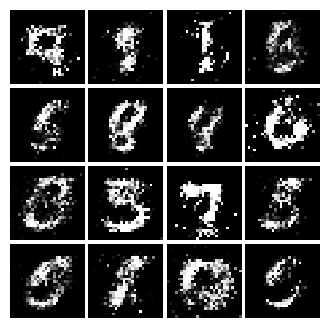

Epoch: 4, Iter: 2160, D: 1.336, G:0.8252


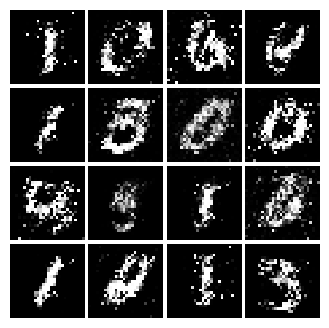

Epoch: 4, Iter: 2180, D: 1.282, G:0.8767


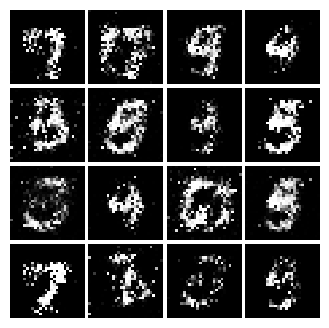

Epoch: 4, Iter: 2200, D: 1.303, G:0.9473


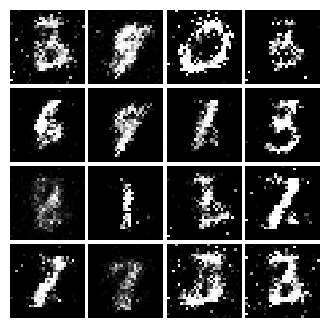

Epoch: 4, Iter: 2220, D: 1.213, G:0.8881


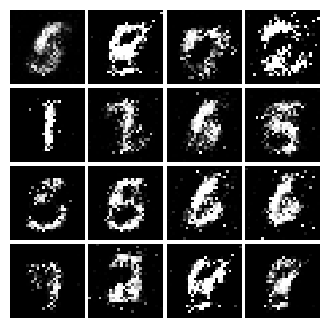

Epoch: 4, Iter: 2240, D: 1.268, G:0.9181


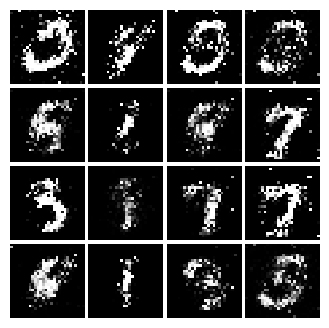

Epoch: 4, Iter: 2260, D: 1.329, G:0.8923


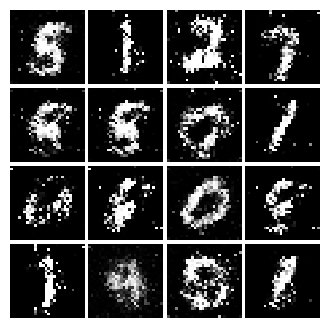

Epoch: 4, Iter: 2280, D: 1.278, G:0.9681


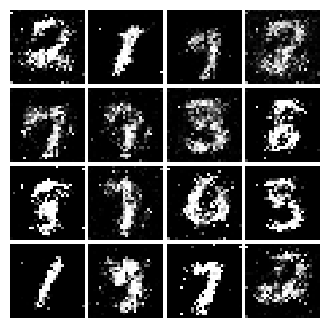

Epoch: 4, Iter: 2300, D: 1.378, G:0.8438


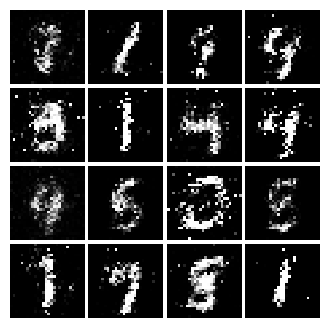

Epoch: 4, Iter: 2320, D: 1.26, G:0.8998


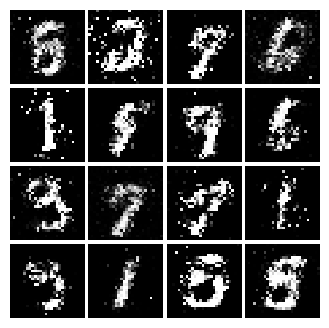

Epoch: 4, Iter: 2340, D: 1.177, G:1.091


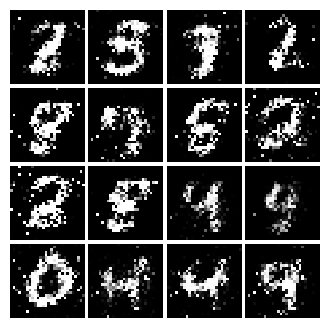

Epoch: 5, Iter: 2360, D: 1.33, G:0.8057


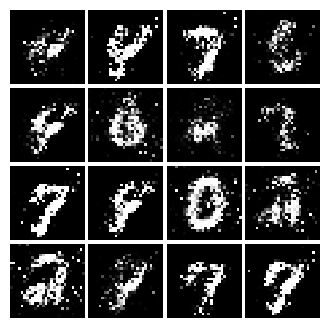

Epoch: 5, Iter: 2380, D: 1.241, G:0.8889


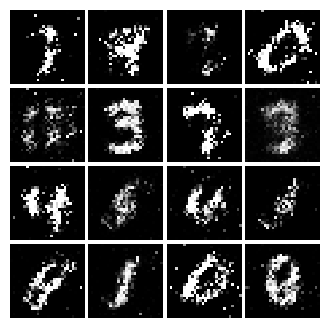

Epoch: 5, Iter: 2400, D: 1.285, G:0.9826


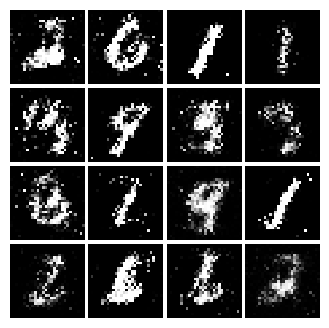

Epoch: 5, Iter: 2420, D: 1.171, G:0.9022


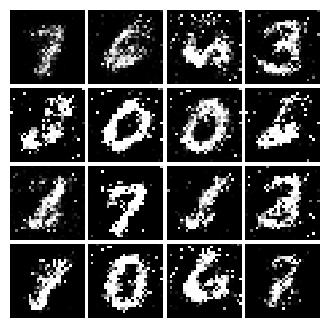

Epoch: 5, Iter: 2440, D: 1.237, G:0.9423


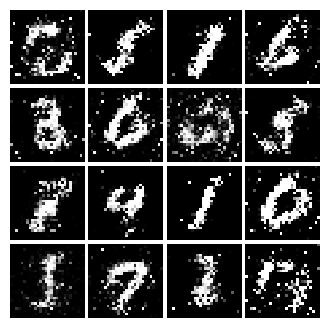

Epoch: 5, Iter: 2460, D: 1.086, G:1.036


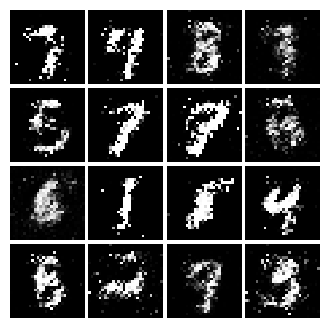

Epoch: 5, Iter: 2480, D: 1.237, G:1.064


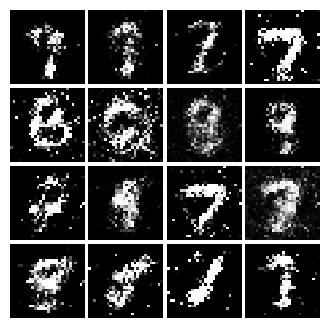

Epoch: 5, Iter: 2500, D: 1.09, G:1.045


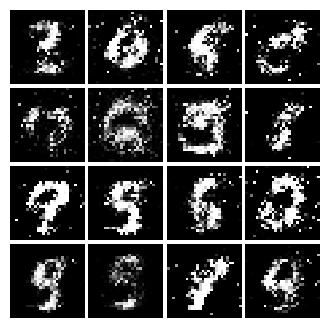

Epoch: 5, Iter: 2520, D: 1.421, G:0.9943


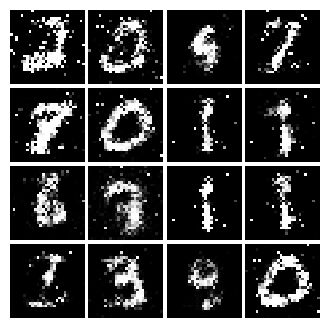

Epoch: 5, Iter: 2540, D: 1.673, G:0.1904


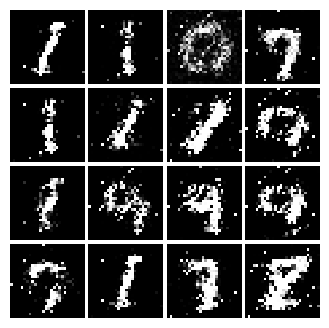

Epoch: 5, Iter: 2560, D: 1.315, G:0.9951


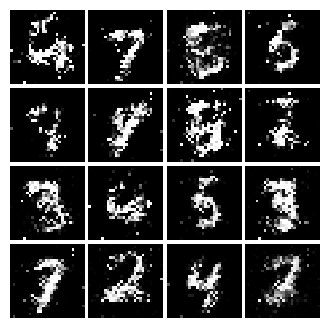

Epoch: 5, Iter: 2580, D: 1.267, G:0.9152


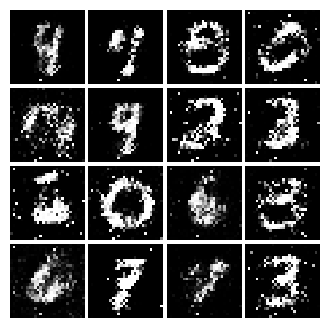

Epoch: 5, Iter: 2600, D: 1.45, G:0.7227


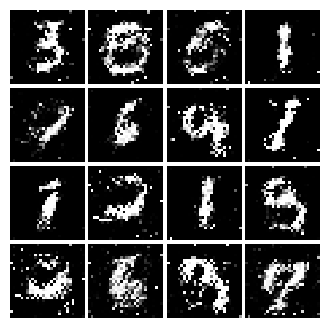

Epoch: 5, Iter: 2620, D: 1.306, G:0.896


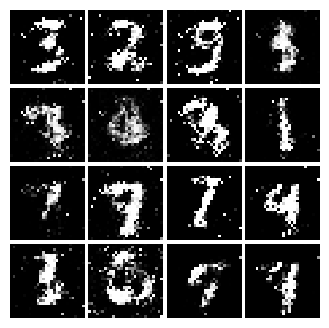

Epoch: 5, Iter: 2640, D: 1.255, G:0.8892


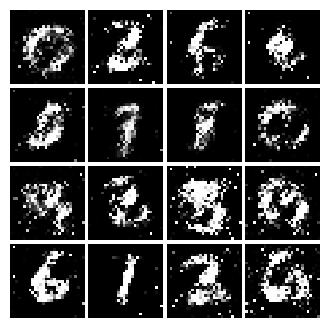

Epoch: 5, Iter: 2660, D: 1.315, G:0.8343


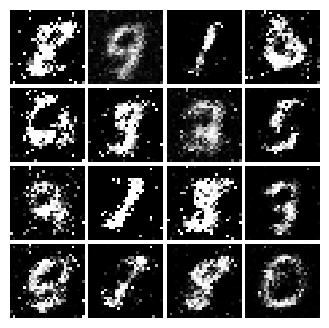

Epoch: 5, Iter: 2680, D: 1.452, G:0.9861


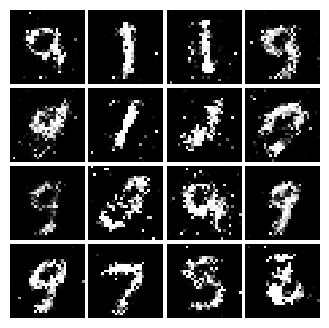

Epoch: 5, Iter: 2700, D: 1.345, G:0.8842


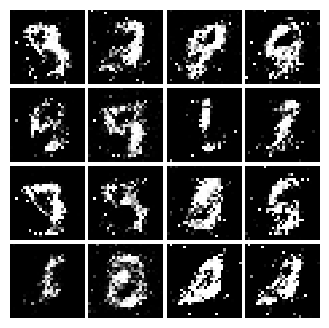

Epoch: 5, Iter: 2720, D: 1.263, G:0.7795


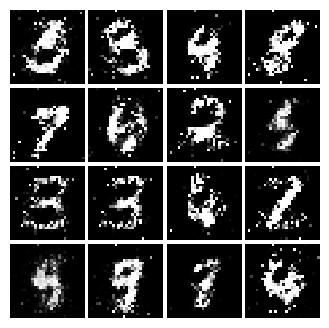

Epoch: 5, Iter: 2740, D: 1.327, G:0.7903


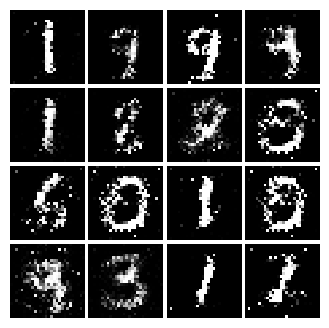

Epoch: 5, Iter: 2760, D: 1.27, G:0.9017


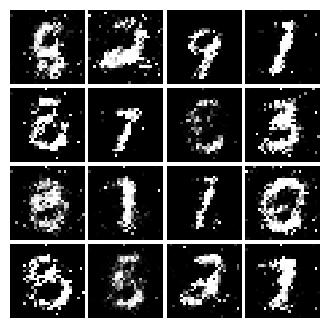

Epoch: 5, Iter: 2780, D: 1.26, G:0.8285


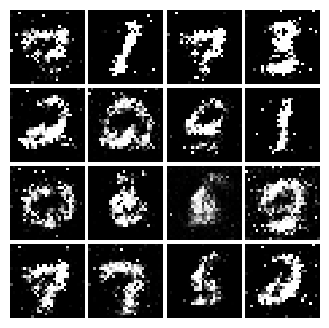

Epoch: 5, Iter: 2800, D: 1.304, G:0.9272


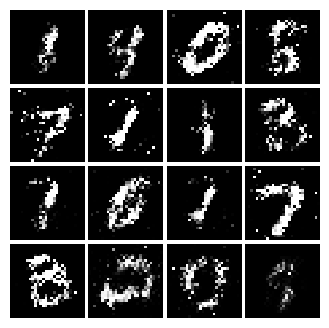

Epoch: 6, Iter: 2820, D: 1.341, G:0.8217


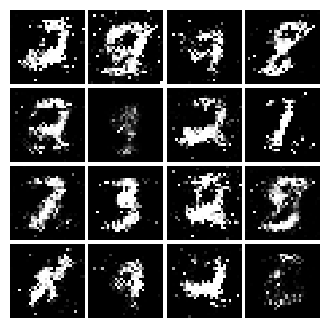

Epoch: 6, Iter: 2840, D: 1.349, G:0.8959


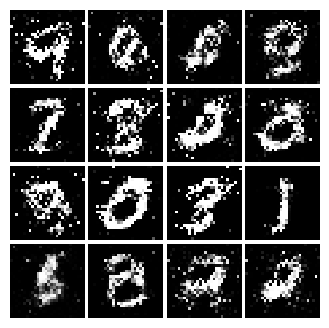

Epoch: 6, Iter: 2860, D: 1.296, G:0.8942


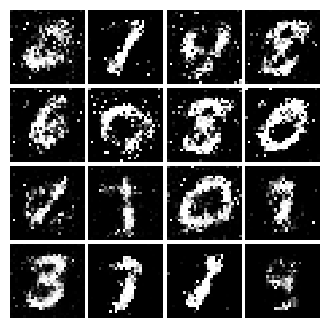

Epoch: 6, Iter: 2880, D: 1.158, G:0.8492


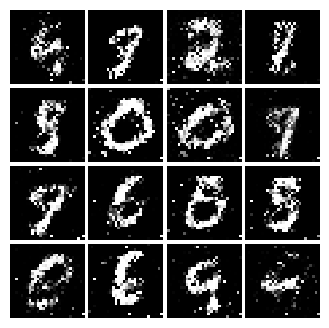

Epoch: 6, Iter: 2900, D: 1.375, G:0.8449


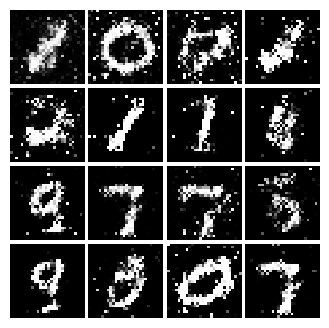

Epoch: 6, Iter: 2920, D: 1.317, G:0.8937


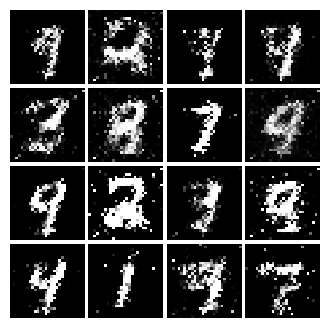

Epoch: 6, Iter: 2940, D: 1.345, G:0.979


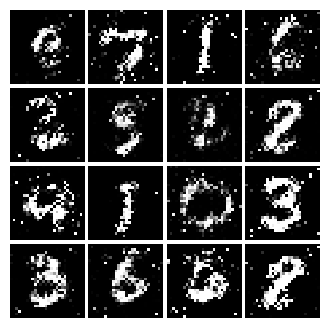

Epoch: 6, Iter: 2960, D: 1.348, G:0.8057


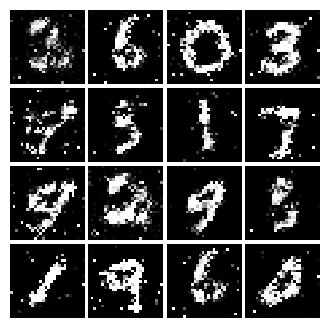

Epoch: 6, Iter: 2980, D: 1.424, G:0.795


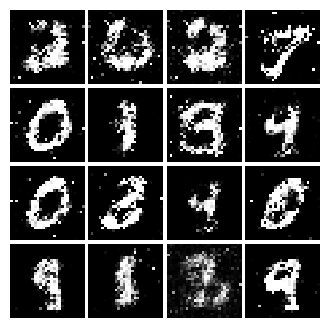

Epoch: 6, Iter: 3000, D: 1.338, G:0.7986


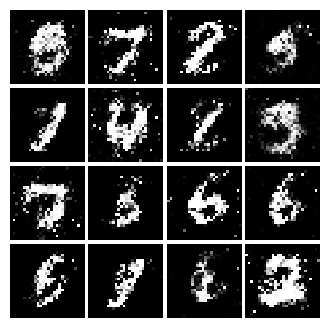

Epoch: 6, Iter: 3020, D: 1.351, G:0.7373


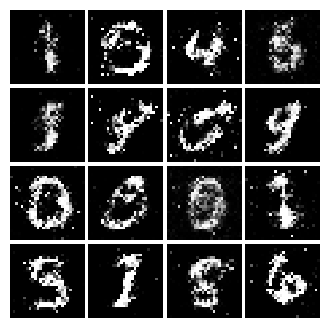

Epoch: 6, Iter: 3040, D: 1.313, G:0.7919


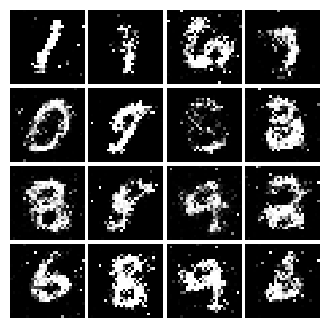

Epoch: 6, Iter: 3060, D: 1.394, G:0.8219


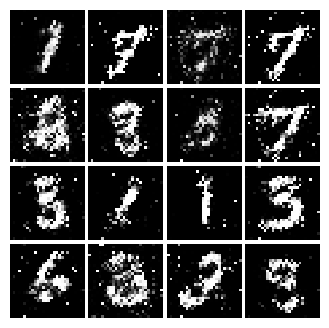

Epoch: 6, Iter: 3080, D: 1.335, G:0.847


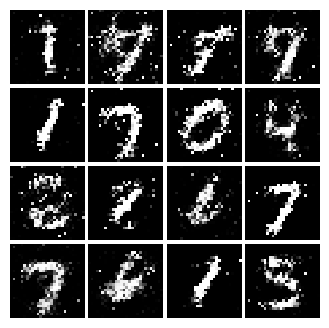

Epoch: 6, Iter: 3100, D: 1.256, G:0.9383


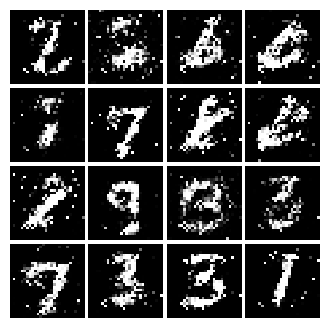

Epoch: 6, Iter: 3120, D: 1.257, G:0.7634


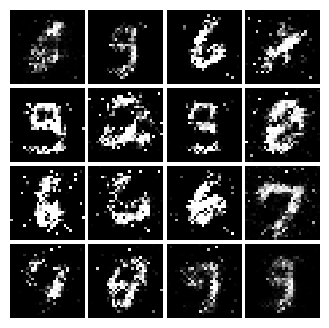

Epoch: 6, Iter: 3140, D: 1.336, G:0.7965


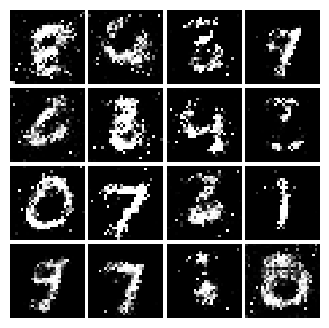

Epoch: 6, Iter: 3160, D: 1.278, G:0.7898


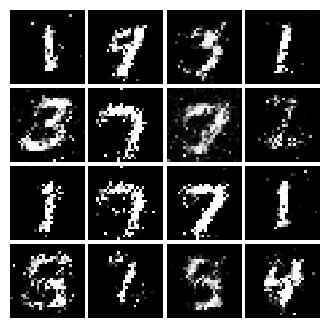

Epoch: 6, Iter: 3180, D: 1.37, G:0.7779


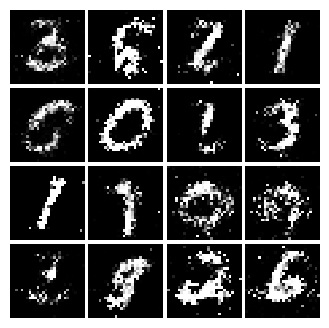

Epoch: 6, Iter: 3200, D: 1.245, G:0.8019


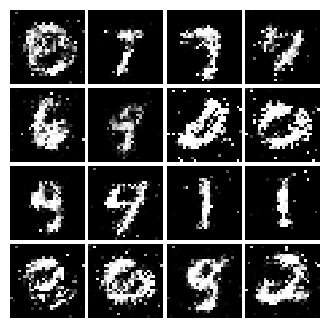

Epoch: 6, Iter: 3220, D: 1.384, G:0.7529


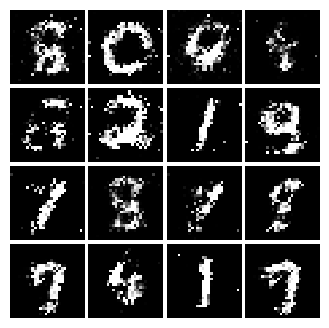

Epoch: 6, Iter: 3240, D: 1.269, G:0.7971


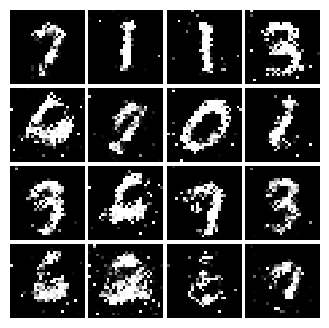

Epoch: 6, Iter: 3260, D: 1.398, G:0.8997


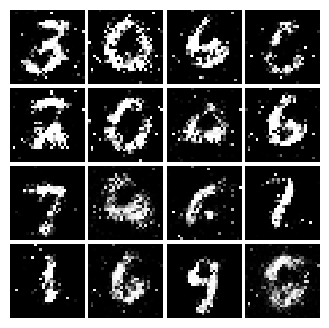

Epoch: 6, Iter: 3280, D: 1.327, G:0.8064


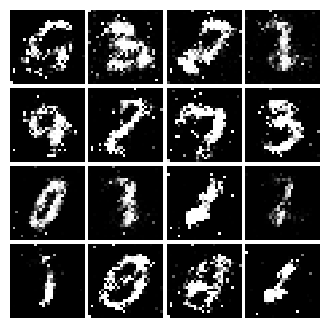

Epoch: 7, Iter: 3300, D: 1.287, G:0.8614


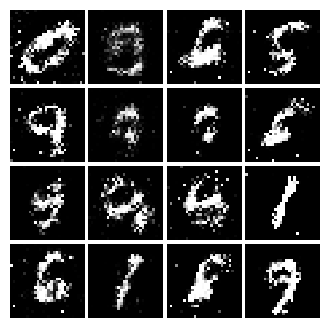

Epoch: 7, Iter: 3320, D: 1.257, G:0.8172


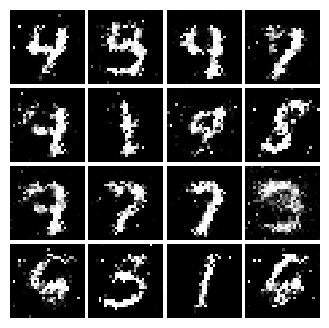

Epoch: 7, Iter: 3340, D: 1.315, G:0.8689


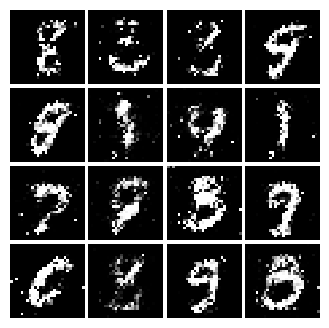

Epoch: 7, Iter: 3360, D: 1.438, G:0.8833


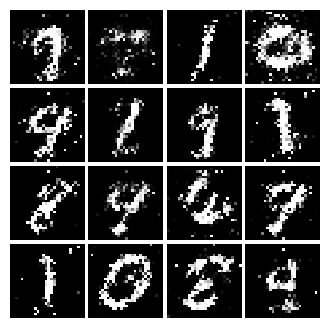

Epoch: 7, Iter: 3380, D: 1.251, G:0.7712


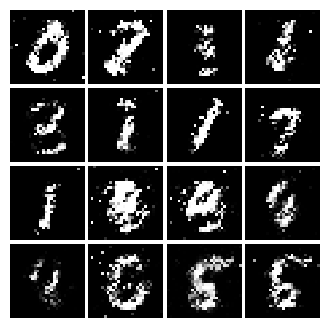

Epoch: 7, Iter: 3400, D: 1.385, G:0.8394


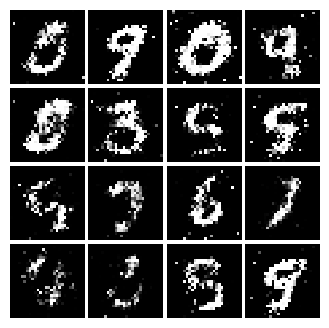

Epoch: 7, Iter: 3420, D: 1.331, G:0.728


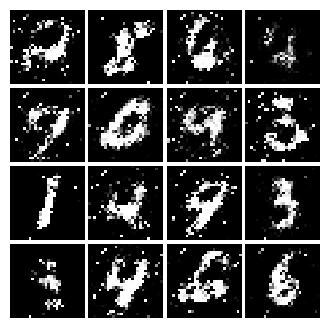

Epoch: 7, Iter: 3440, D: 1.31, G:0.8998


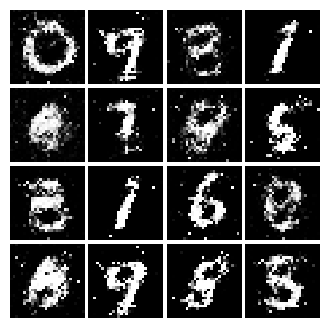

Epoch: 7, Iter: 3460, D: 1.298, G:0.7281


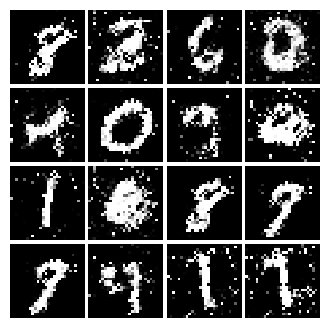

Epoch: 7, Iter: 3480, D: 1.359, G:0.8


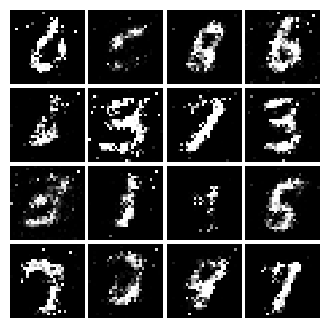

Epoch: 7, Iter: 3500, D: 1.265, G:0.8677


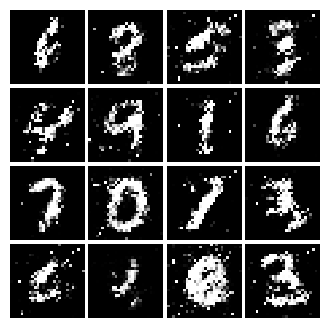

Epoch: 7, Iter: 3520, D: 1.26, G:0.7033


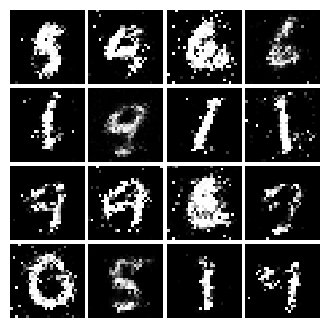

Epoch: 7, Iter: 3540, D: 1.277, G:1.274


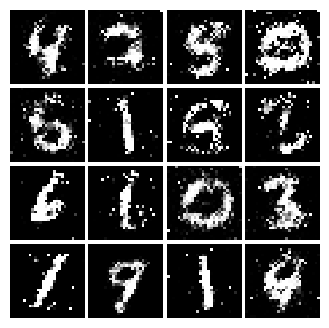

Epoch: 7, Iter: 3560, D: 1.232, G:0.8488


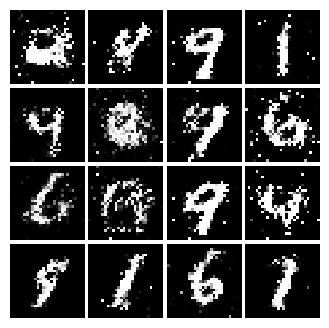

Epoch: 7, Iter: 3580, D: 1.267, G:0.8201


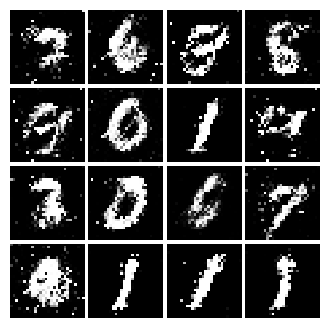

Epoch: 7, Iter: 3600, D: 1.315, G:0.9446


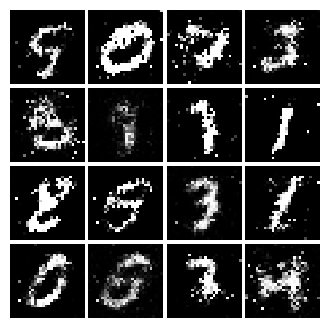

Epoch: 7, Iter: 3620, D: 1.281, G:0.7589


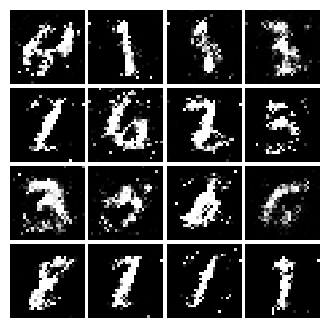

Epoch: 7, Iter: 3640, D: 1.307, G:0.7856


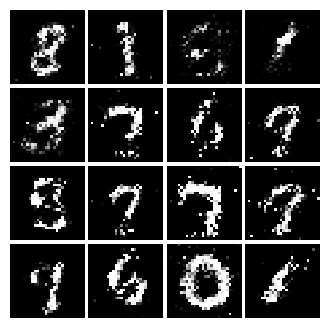

Epoch: 7, Iter: 3660, D: 1.369, G:0.7383


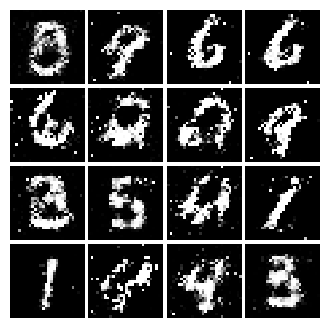

Epoch: 7, Iter: 3680, D: 1.276, G:0.8079


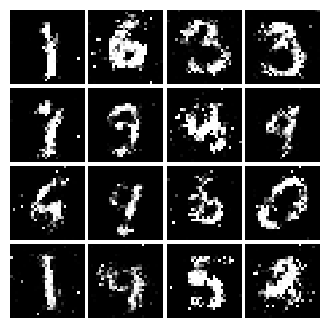

Epoch: 7, Iter: 3700, D: 1.319, G:0.7986


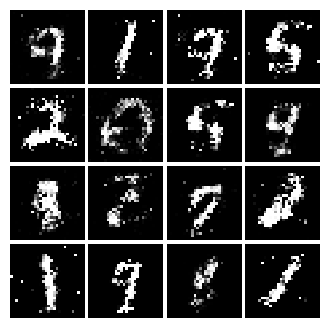

Epoch: 7, Iter: 3720, D: 1.314, G:0.7276


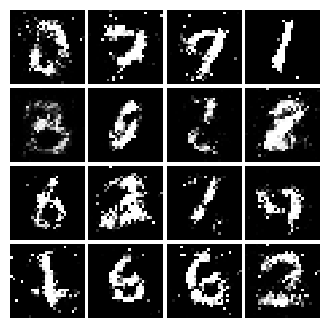

Epoch: 7, Iter: 3740, D: 1.351, G:0.7721


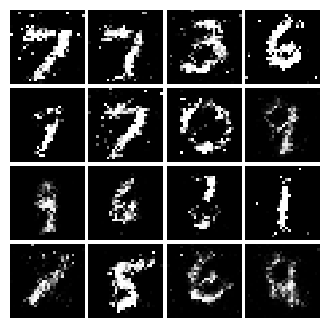

Epoch: 8, Iter: 3760, D: 1.284, G:0.7169


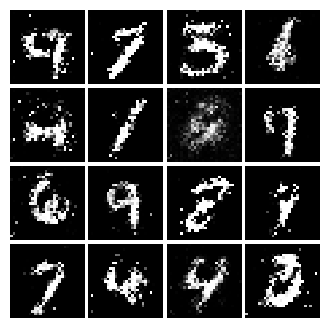

Epoch: 8, Iter: 3780, D: 1.37, G:0.8337


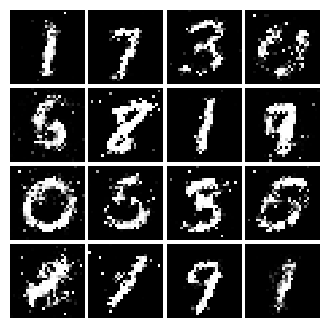

Epoch: 8, Iter: 3800, D: 1.308, G:0.8088


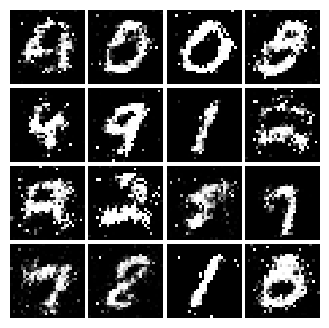

Epoch: 8, Iter: 3820, D: 1.296, G:0.9386


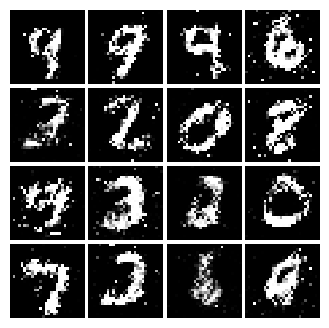

Epoch: 8, Iter: 3840, D: 1.34, G:0.7639


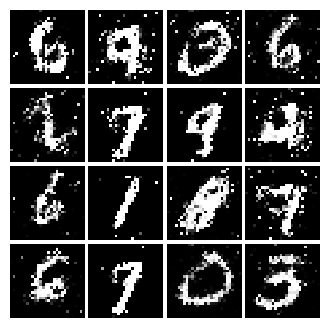

Epoch: 8, Iter: 3860, D: 1.368, G:0.7442


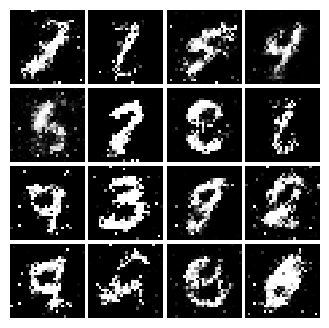

Epoch: 8, Iter: 3880, D: 1.268, G:0.8321


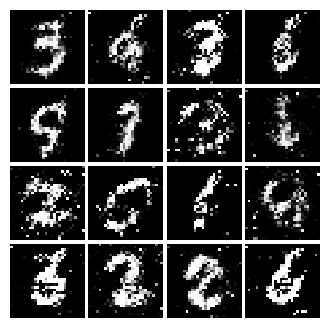

Epoch: 8, Iter: 3900, D: 1.373, G:0.834


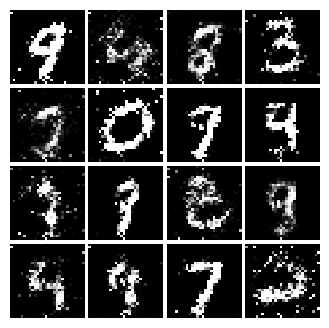

Epoch: 8, Iter: 3920, D: 1.255, G:0.8125


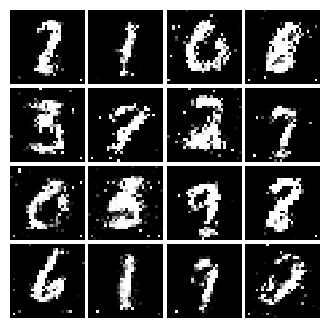

Epoch: 8, Iter: 3940, D: 1.285, G:0.8072


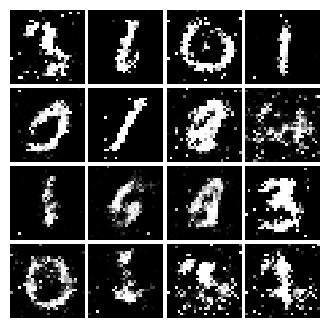

Epoch: 8, Iter: 3960, D: 1.407, G:0.8101


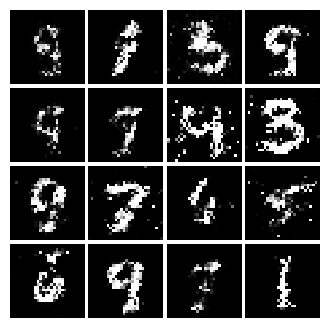

Epoch: 8, Iter: 3980, D: 1.321, G:0.8094


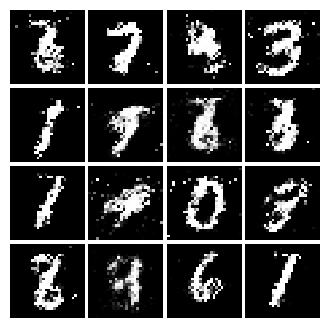

Epoch: 8, Iter: 4000, D: 1.284, G:0.8617


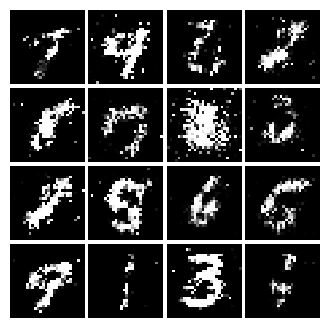

Epoch: 8, Iter: 4020, D: 1.329, G:0.8042


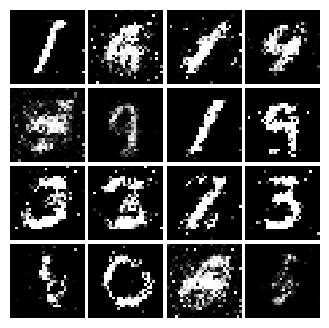

Epoch: 8, Iter: 4040, D: 1.381, G:0.8516


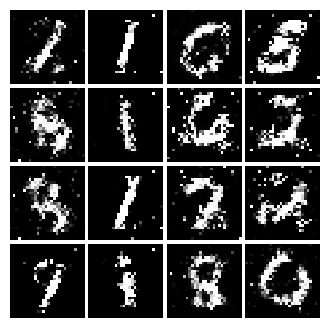

Epoch: 8, Iter: 4060, D: 1.31, G:0.8092


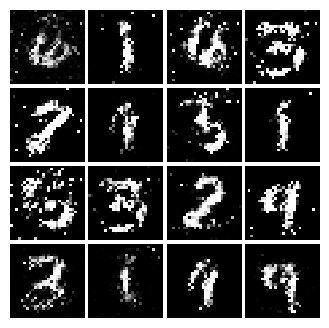

Epoch: 8, Iter: 4080, D: 1.363, G:0.7578


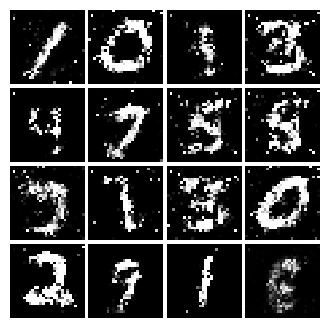

Epoch: 8, Iter: 4100, D: 1.375, G:0.7547


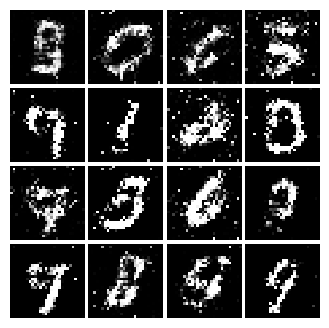

Epoch: 8, Iter: 4120, D: 1.32, G:0.8536


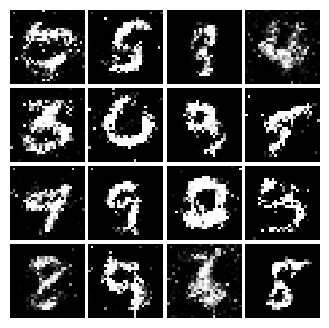

Epoch: 8, Iter: 4140, D: 1.358, G:0.7953


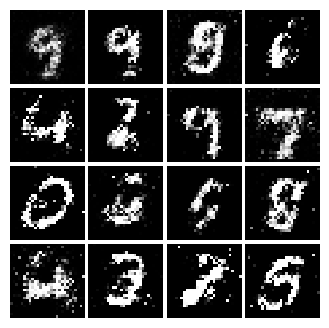

Epoch: 8, Iter: 4160, D: 1.412, G:0.8117


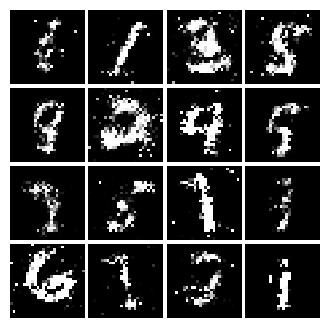

Epoch: 8, Iter: 4180, D: 1.375, G:0.8533


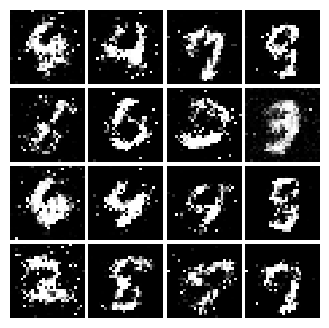

Epoch: 8, Iter: 4200, D: 1.392, G:0.8167


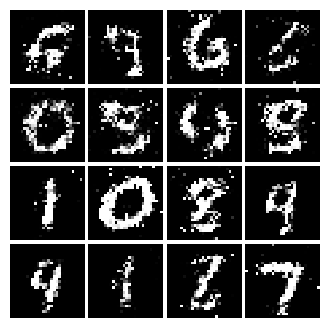

Epoch: 8, Iter: 4220, D: 1.341, G:0.6782


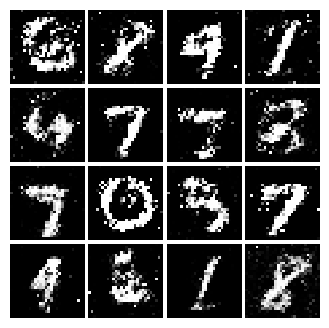

Epoch: 9, Iter: 4240, D: 1.377, G:0.7646


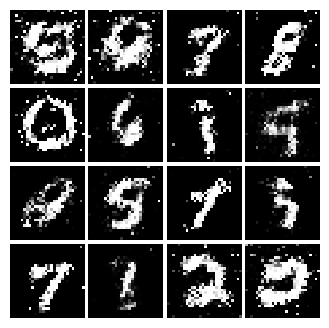

Epoch: 9, Iter: 4260, D: 1.375, G:0.7707


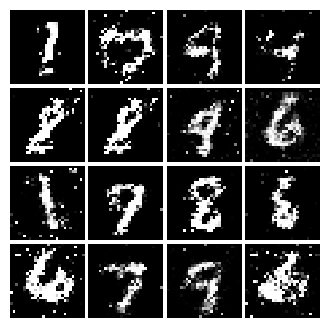

Epoch: 9, Iter: 4280, D: 1.352, G:0.846


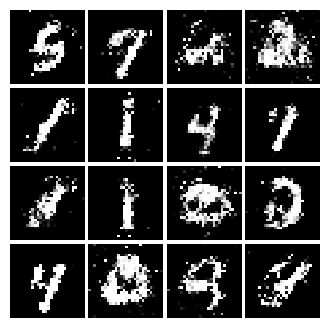

Epoch: 9, Iter: 4300, D: 1.302, G:0.7867


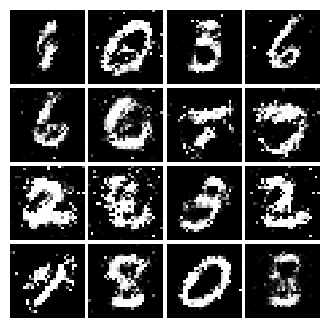

Epoch: 9, Iter: 4320, D: 1.413, G:0.7832


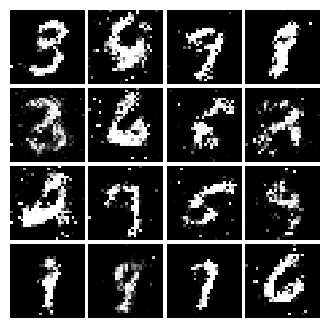

Epoch: 9, Iter: 4340, D: 1.345, G:0.7395


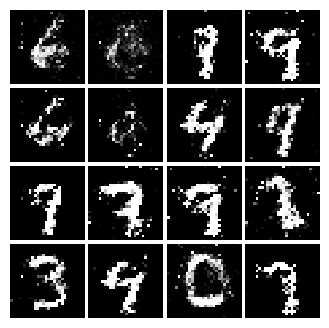

Epoch: 9, Iter: 4360, D: 1.398, G:0.8115


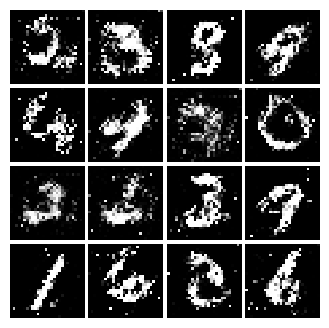

Epoch: 9, Iter: 4380, D: 1.382, G:0.7584


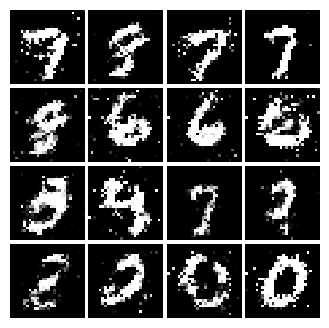

Epoch: 9, Iter: 4400, D: 1.236, G:0.8844


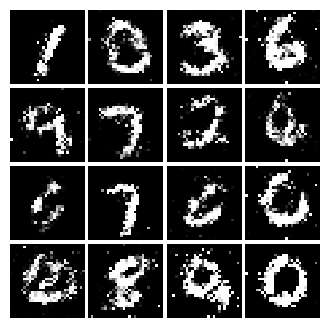

Epoch: 9, Iter: 4420, D: 1.299, G:0.8116


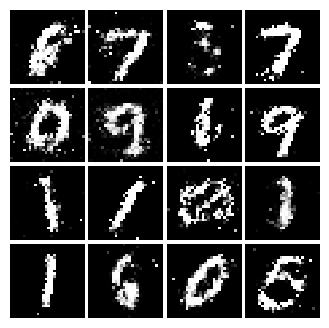

Epoch: 9, Iter: 4440, D: 1.313, G:0.8106


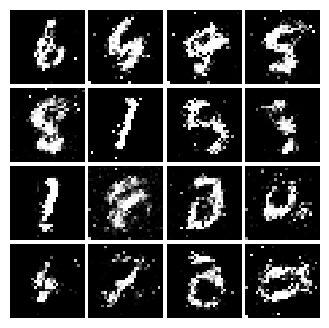

Epoch: 9, Iter: 4460, D: 1.376, G:0.818


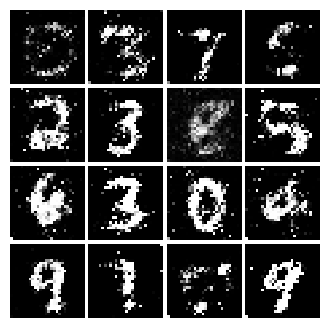

Epoch: 9, Iter: 4480, D: 1.296, G:0.8373


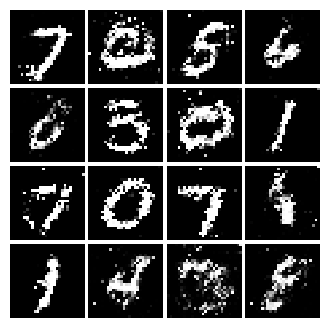

Epoch: 9, Iter: 4500, D: 1.373, G:0.8428


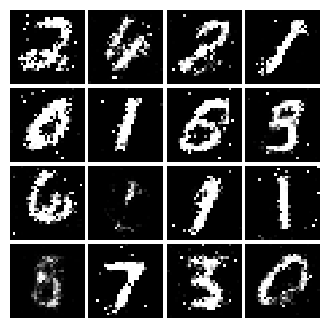

Epoch: 9, Iter: 4520, D: 1.356, G:0.8448


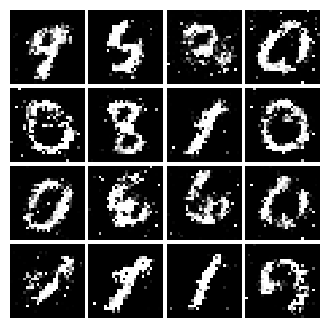

Epoch: 9, Iter: 4540, D: 1.365, G:0.8369


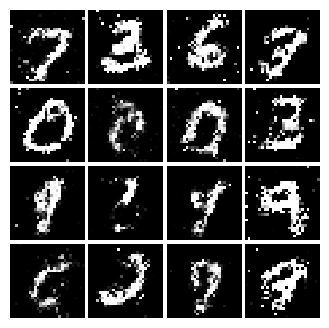

Epoch: 9, Iter: 4560, D: 1.294, G:0.7787


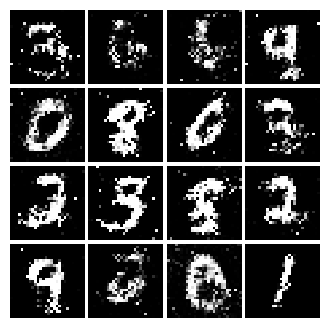

Epoch: 9, Iter: 4580, D: 1.286, G:0.8562


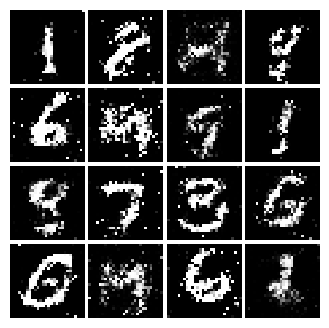

Epoch: 9, Iter: 4600, D: 1.374, G:0.816


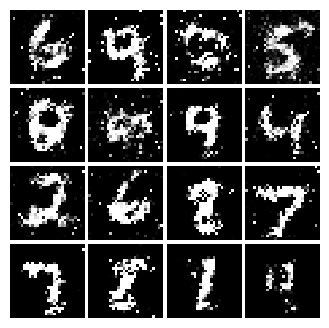

Epoch: 9, Iter: 4620, D: 1.425, G:0.7786


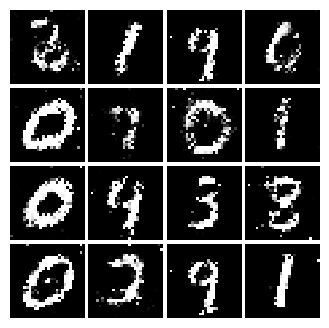

Epoch: 9, Iter: 4640, D: 1.361, G:0.7255


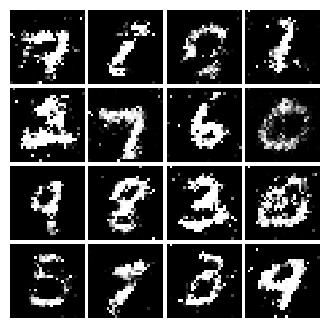

Epoch: 9, Iter: 4660, D: 1.355, G:0.8066


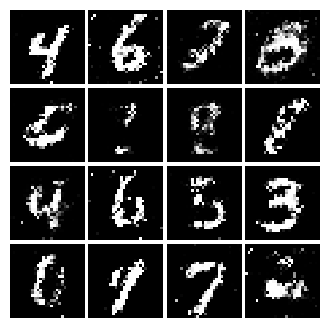

Epoch: 9, Iter: 4680, D: 1.357, G:0.7414


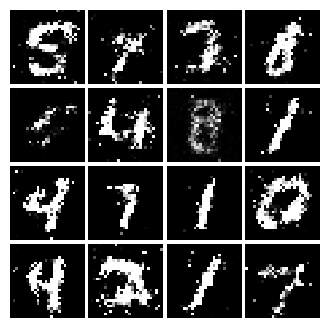

Final images


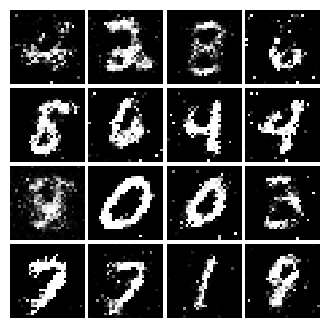

In [11]:
# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

## Your turn! 🚀

Implement TODO part of the code in this notebook.

Assignment - [Art by gan](../assignments/deep-learning/gan/art-by-gan.ipynb)

## Acknowledgments

Thanks to [Sebastian Raschka](https://github.com/rasbt) for creating the open-source project [stat453-deep-learning-ss20](https://github.com/rasbt/stat453-deep-learning-ss20) and [Diego Gomez](https://github.com/diegoalejogm) for creating the open-source project [gans](https://github.com/diegoalejogm/gans). They inspire the majority of the content in this chapter.
